<a href="https://colab.research.google.com/github/ichi08/vae_with_cnn/blob/colab/VAE_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture 1 ; use only CNN

## import library

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import time
from tqdm import tqdm

## prepare datasets

In [3]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST(
    root='./data'
    , train=True
    , download=True
    , transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset
    , batch_size=batch_size
    , shuffle=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



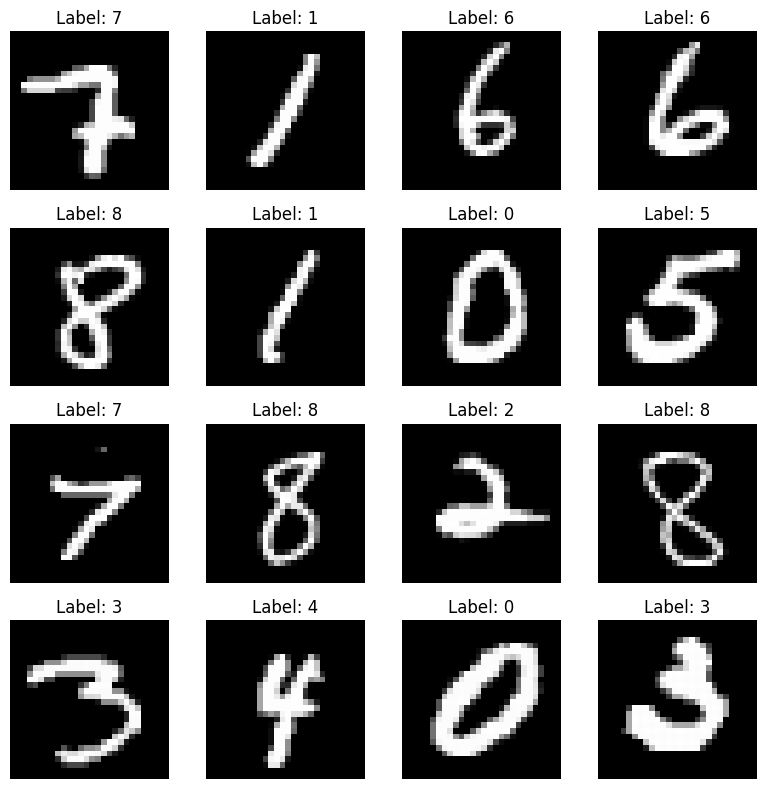

In [4]:
# check images of datasets

# Get a batch of data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# 4x4 のグリッドで画像を表示
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    image = images[i].numpy().reshape(28, 28)  # 画像を元の形にリシェイプ
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')  # 軸を非表示にする

plt.tight_layout()
plt.show()

In [ ]:
image.size

784

## set parameter

In [ ]:
# ハイパーパラメータの設定
latent_dim = 4 * 4
learning_rate = 3e-4
batch_size = 32
epochs = 50

## create VAE used CNN

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(Encoder, self).__init__()
        self.kernel_num = 32 * times
        self.conv1 = nn.Conv2d(1, self.kernel_num, kernel_size=3, stride=1, padding=1)  # Feature extraction
        self.conv2 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=1, padding=1)  # Maintain 32 channels
        self.conv3 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=1, padding=1)  # Maintain 32 channels
        self.downsample1 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)  # Downsampling
        self.downsample2 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)  # Further Downsampling
        self.downsample3 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)  # Further Downsampling
        self.conv_for_mu = nn.Conv2d(self.kernel_num, self.kernel_num//2, kernel_size=3, stride=1, padding=1)
        self.conv_for_logvar = nn.Conv2d(self.kernel_num, self.kernel_num//2, kernel_size=3, stride=1, padding=1)
        self.activation = nn.SiLU()
        self.batch_size = batch_size

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.downsample1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.downsample2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.downsample3(x))
        mu = self.activation(self.conv_for_mu(x))
        logvar = self.activation(self.conv_for_logvar(x))
        mu = torch.flatten(mu, start_dim=1)
        logvar = torch.flatten(logvar, start_dim=1)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(Decoder, self).__init__()
        self.kernel_num = 32 * times
        self.conv1 = nn.Conv2d(self.kernel_num//2, self.kernel_num, kernel_size=3, stride=1, padding=1)  # Feature extraction
        self.conv2 = nn.Conv2d(self.kernel_num, self.kernel_num//2, kernel_size=3, stride=1, padding=1)  # Maintain 32 channels
        self.conv3 = nn.Conv2d(self.kernel_num//2, self.kernel_num//4, kernel_size=3, stride=1, padding=1)  # Maintain 32 channels
        self.upsample1 = nn.ConvTranspose2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1,  output_padding=0) # to adjust expected size of outputs
        self.upsample2 = nn.ConvTranspose2d(self.kernel_num//2, self.kernel_num//2, kernel_size=3, stride=2, padding=1,  output_padding=1)
        self.upsample3 = nn.ConvTranspose2d(self.kernel_num//4, self.kernel_num//4, kernel_size=3, stride=2, padding=1,  output_padding=1)
        self.deconv_final = nn.ConvTranspose2d(self.kernel_num//4, 1, kernel_size=3, stride=1, padding=1)
        self.activation = nn.SiLU()
        self.batch_size = batch_size

    def forward(self, z):
        # print(z.shape) # (batch_size, 256)
        x = z.view(self.batch_size, self.kernel_num//2, 4, 4)
        x = self.activation(self.conv1(x))
        x = self.activation(self.upsample1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.upsample2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.upsample3(x))
        x = self.deconv_final(x)
        x_hat = F.sigmoid(x)
        return x_hat

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, times=times, batch_size=batch_size)
        self.decoder = Decoder(latent_dim=latent_dim, times=times, batch_size=batch_size)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
        return (L1 + L2) / batch_size

In [ ]:
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + sigma * eps

## Let model learn

In [ ]:
# https://cloud.google.com/tpu/docs/intro-to-tpu?hl=ja
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if you want to use TPU, enable following code
# import torch_xla
# import torch_xla.core.xla_model as xm

# device = xm.xla_device()

print(device)

cuda


In [ ]:
# time to learn for model takes me 12.25 minutes when times=1 and epoch=50
# time to learn for model takes me  minutes when times=2 and epoch=50
model = VAE(latent_dim=latent_dim, times=1, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

epoch_start_time = time.time()

for epoch in tqdm(range(epochs)):
    loss_sum = 0
    cnt = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)

epoch_end_time = time.time()

epoch_duration = epoch_end_time - epoch_start_time

100%|██████████| 50/50 [13:59<00:00, 16.79s/it]


In [ ]:
print(f"{epoch_duration/60:.2f} minutes")

13.99 minutes


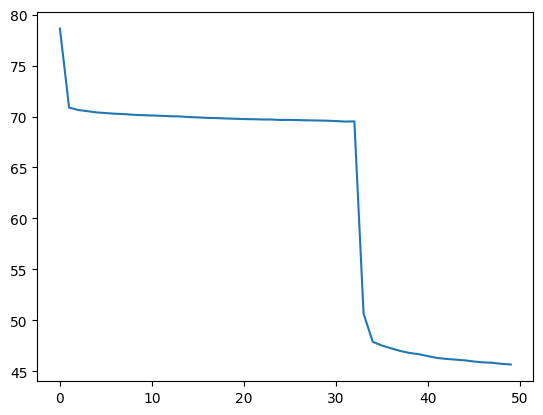

In [ ]:
# show the loss value trends
plt.plot(losses)
plt.show()

## generate image

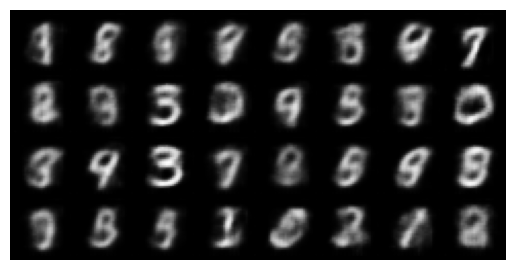

In [ ]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, 8 * 4 * 4)
    x = model.to('cpu').decoder(z)
    generated_images = x.view(sample_size//2, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images
    , nrow=8
    , padding=2
    , normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
model

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (downsample2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (downsample3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_for_mu): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_for_logvar): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): SiLU()
  )
  (decoder): Decoder(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upsample1): Conv

## Architecture 1 : increase number of parameter

In [ ]:
model_3_times = VAE(latent_dim=latent_dim, times=3, batch_size=batch_size).to(device)
optimizer = optim.Adam(model_3_times.parameters(), lr=learning_rate)
losses = []

epoch_start_time = time.time()

for epoch in tqdm(range(epochs)):
    loss_sum = 0
    cnt = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model_3_times.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)

epoch_end_time = time.time()

epoch_duration = epoch_end_time - epoch_start_time

100%|██████████| 50/50 [15:17<00:00, 18.36s/it]


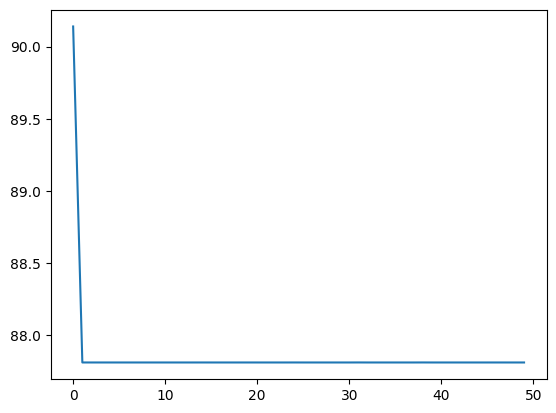

In [ ]:
# show the loss value trends
plt.plot(losses)
plt.show()

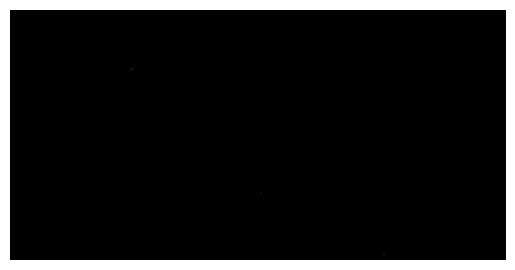

In [ ]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, 8 * 3 * 4 * 4) # the 3 means times you use in model training
    x = model_3_times.to('cpu').decoder(z)
    generated_images = x.view(sample_size//2, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images
    , nrow=8
    , padding=2
    , normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
model_3_times

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample1): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (downsample2): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (downsample3): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_for_mu): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_for_logvar): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): SiLU()
  )
  (decoder): Decoder(
    (conv1): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upsample1): Con

## Architecture 1 : reduce number of parameter of model

In [ ]:
model_half = VAE(latent_dim=latent_dim, times=2, batch_size=batch_size).to(device)
optimizer = optim.Adam(model_half.parameters(), lr=learning_rate)
losses = []

epoch_start_time = time.time()

for epoch in tqdm(range(epochs)):
    loss_sum = 0
    cnt = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model_half.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)

epoch_end_time = time.time()

epoch_duration = epoch_end_time - epoch_start_time

100%|██████████| 50/50 [13:49<00:00, 16.58s/it]


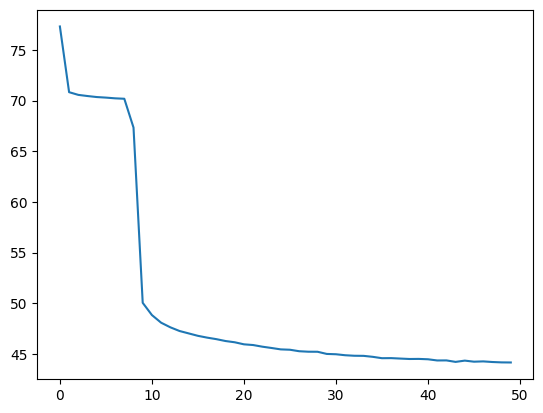

In [ ]:
# show the loss value trends
plt.plot(losses)
plt.show()

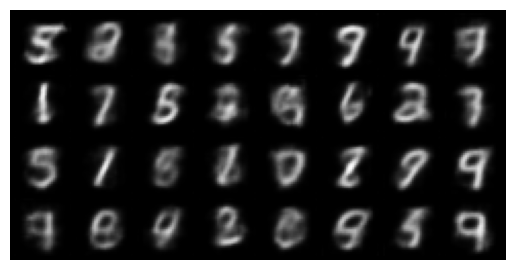

In [ ]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, 8 * 2 * 4 * 4) # the 3 means times you use in model training
    x = model_half.to('cpu').decoder(z)
    generated_images = x.view(sample_size//2, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images
    , nrow=8
    , padding=2
    , normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
model_half

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (downsample2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (downsample3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_for_mu): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_for_logvar): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): SiLU()
  )
  (decoder): Decoder(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upsample1): Con

# Architecture 2 containing FC before estimating the mean and the sigma

## simpel parameter

In [ ]:
# ハイパーパラメータの設定
input_dim = 28 * 28
latent_dim = 4 * 4
learning_rate = 3e-4
batch_size = 32
epochs = 50


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(Encoder, self).__init__()
        self.kernel_num = 32 * times
        self.conv1 = nn.Conv2d(1, self.kernel_num, kernel_size=3, stride=1, padding=1)  # Feature extraction
        self.conv2 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=1, padding=1)  # Maintain 32 channels
        self.conv3 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=1, padding=1)  # Maintain 32 channels
        self.downsample1 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)  # Downsampling
        self.downsample2 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)  # Further Downsampling
        self.downsample3 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)  # Further Downsampling
        self.fc_for_mean = nn.Linear(self.kernel_num * 4 * 4, 4 * 4)
        self.fc_for_logvar = nn.Linear(self.kernel_num * 4 * 4, 4 * 4)
        self.activation = nn.SiLU()
        self.batch_size = batch_size

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.downsample1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.downsample2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.downsample3(x))
        x = torch.flatten(x, start_dim=1) # size 32(=barch size) * 4 * 4(=latent_dim)
        # Treat the first half as the mean and the second half as the sigma(variance)
        mu = self.fc_for_mean(x)
        logvar = self.fc_for_logvar(x)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(Decoder, self).__init__()
        self.kernel_num = 32 * times
        self.fc = nn.Linear(latent_dim, self.kernel_num * 4 * 4)
        self.conv1 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=1, padding=1)  # Feature extraction
        self.conv2 = nn.Conv2d(self.kernel_num, self.kernel_num//2, kernel_size=3, stride=1, padding=1)  # Maintain 32 channels
        self.conv3 = nn.Conv2d(self.kernel_num//2, self.kernel_num//4, kernel_size=3, stride=1, padding=1)  # Maintain 32 channels
        self.upsample1 = nn.ConvTranspose2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1,  output_padding=0) # to adjust expected size of outputs
        self.upsample2 = nn.ConvTranspose2d(self.kernel_num//2, self.kernel_num//2, kernel_size=3, stride=2, padding=1,  output_padding=1)
        self.upsample3 = nn.ConvTranspose2d(self.kernel_num//4, self.kernel_num//4, kernel_size=3, stride=2, padding=1,  output_padding=1)
        self.deconv_final = nn.ConvTranspose2d(self.kernel_num//4, 1, kernel_size=3, stride=1, padding=1)
        self.activation = nn.SiLU()
        self.batch_size = batch_size

    def forward(self, z):
        batch_size = z.shape[0]
        x = self.activation(self.fc(z)).view(batch_size, self.kernel_num, 4, 4)
        x = self.activation(self.conv1(x))
        x = self.activation(self.upsample1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.upsample2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.upsample3(x))
        x = self.deconv_final(x)
        x_hat = F.sigmoid(x)
        return x_hat

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, times=times, batch_size=batch_size)
        self.decoder = Decoder(latent_dim=latent_dim, times=times, batch_size=batch_size)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
        return (L1 + L2) / batch_size

In [ ]:
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + sigma * eps

In [ ]:
model_add_fc = VAE(latent_dim=latent_dim, times=1, batch_size=batch_size).to(device)
optimizer = optim.Adam(model_add_fc.parameters(), lr=learning_rate)
losses = []

epoch_start_time = time.time()

for epoch in tqdm(range(epochs)):
    loss_sum = 0
    cnt = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model_add_fc.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)

epoch_end_time = time.time()

epoch_duration = epoch_end_time - epoch_start_time

100%|██████████| 50/50 [13:35<00:00, 16.31s/it]


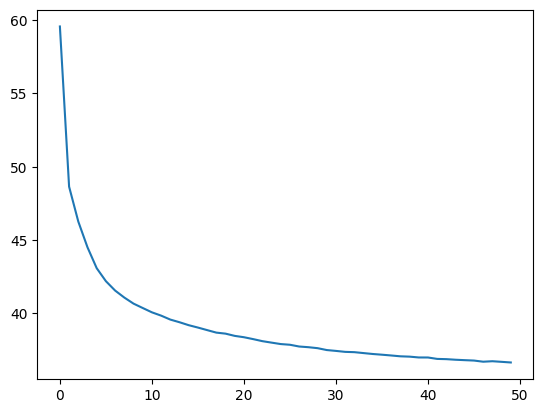

In [ ]:
# show the loss value trends
plt.plot(losses)
plt.show()

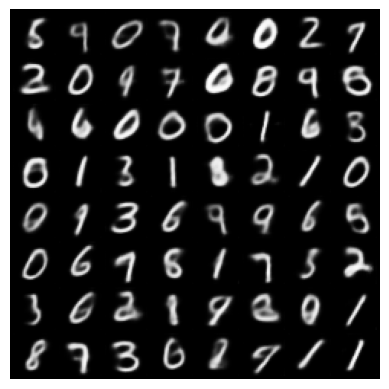

In [ ]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, 4 * 4) # the 3 means times you use in model training
    x = model_add_fc.to('cpu').decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images
    , nrow=8
    , padding=2
    , normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

## half parameter

In [ ]:
model_add_fc_half = VAE(latent_dim=latent_dim, times=2, batch_size=batch_size).to(device)
optimizer = optim.Adam(model_add_fc_half.parameters(), lr=learning_rate)
losses = []

epoch_start_time = time.time()

for epoch in tqdm(range(epochs)):
    loss_sum = 0
    cnt = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model_add_fc_half.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)

epoch_end_time = time.time()

epoch_duration = epoch_end_time - epoch_start_time

100%|██████████| 50/50 [14:00<00:00, 16.81s/it]


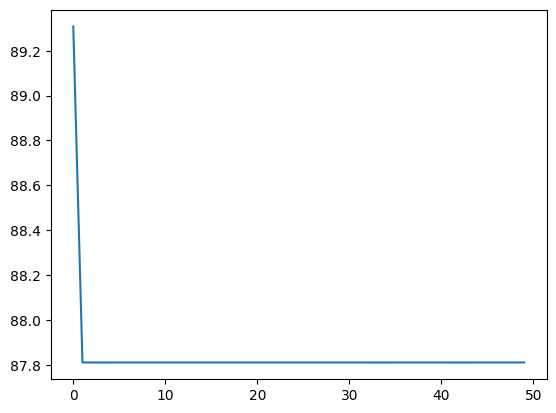

In [ ]:
# show the loss value trends
plt.plot(losses)
plt.show()

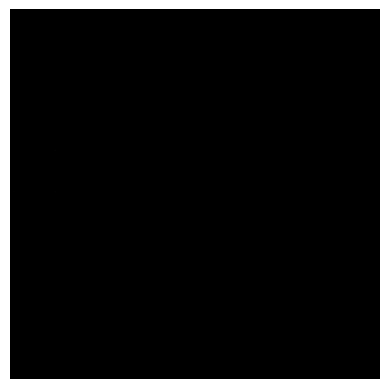

In [ ]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, 4 * 4) # the 3 means times you use in model training
    x = model_add_fc_half.to('cpu').decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images
    , nrow=8
    , padding=2
    , normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
model_add_fc_half

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (downsample2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (downsample3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_for_mean): Linear(in_features=1024, out_features=16, bias=True)
    (fc_for_logvar): Linear(in_features=1024, out_features=16, bias=True)
    (activation): SiLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=16, out_features=1024, bias=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), p

## triple parameter

In [ ]:
model_add_fc_triple = VAE(latent_dim=latent_dim, times=3, batch_size=batch_size).to(device)
optimizer = optim.Adam(model_add_fc_triple.parameters(), lr=learning_rate)
losses = []

epoch_start_time = time.time()

for epoch in tqdm(range(epochs)):
    loss_sum = 0
    cnt = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model_add_fc_triple.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)

epoch_end_time = time.time()

epoch_duration = epoch_end_time - epoch_start_time

100%|██████████| 50/50 [15:12<00:00, 18.25s/it]


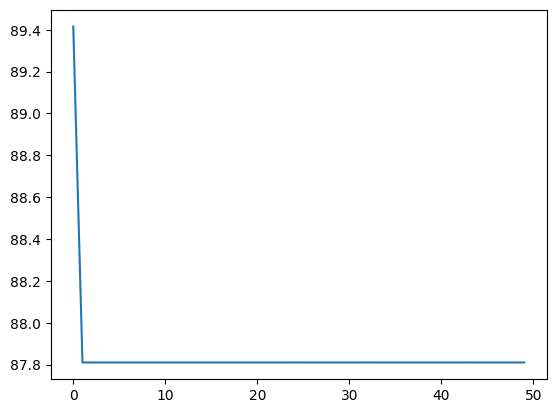

In [ ]:
# show the loss value trends
plt.plot(losses)
plt.show()

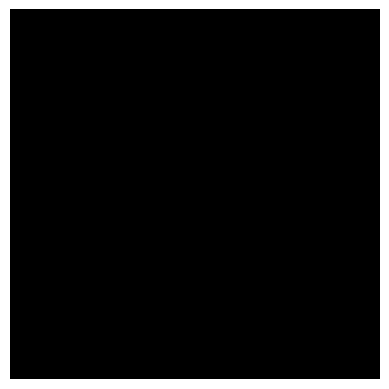

In [ ]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, 4 * 4) # the 3 means times you use in model training
    x = model_add_fc_triple.to('cpu').decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images
    , nrow=8
    , padding=2
    , normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
model_add_fc_triple

# Batch Normalize

In [11]:
# ハイパーパラメータの設定
latent_dim = 4 * 4
learning_rate = 3e-4
batch_size = 32
epochs = 50
device = 'cuda'

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(Encoder, self).__init__()
        self.kernel_num = 32 * times

        self.conv1 = nn.Conv2d(1, self.kernel_num, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.kernel_num)

        self.conv2 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.kernel_num)

        self.conv3 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.kernel_num)

        self.downsample1 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)
        self.bn_ds1 = nn.BatchNorm2d(self.kernel_num)

        self.downsample2 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)
        self.bn_ds2 = nn.BatchNorm2d(self.kernel_num)

        self.downsample3 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1)
        self.bn_ds3 = nn.BatchNorm2d(self.kernel_num)

        self.fc_for_mean = nn.Linear(self.kernel_num * 4 * 4, latent_dim)
        self.bn_fc_mean = nn.BatchNorm1d(latent_dim)

        self.fc_for_logvar = nn.Linear(self.kernel_num * 4 * 4, latent_dim)
        self.bn_fc_logvar = nn.BatchNorm1d(latent_dim)

        self.activation = nn.SiLU()
        self.batch_size = batch_size

    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn_ds1(self.downsample1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn_ds2(self.downsample2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.bn_ds3(self.downsample3(x)))

        x = torch.flatten(x, start_dim=1)

        mu = self.bn_fc_mean(self.fc_for_mean(x))
        logvar = self.bn_fc_logvar(self.fc_for_logvar(x))
        sigma = torch.exp(0.5 * logvar)

        return mu, sigma

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(Decoder, self).__init__()
        self.kernel_num = 32 * times

        self.fc = nn.Linear(latent_dim, self.kernel_num * 4 * 4)
        self.bn_fc = nn.BatchNorm1d(self.kernel_num * 4 * 4)

        self.conv1 = nn.Conv2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.kernel_num)

        self.conv2 = nn.Conv2d(self.kernel_num, self.kernel_num // 2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.kernel_num // 2)

        self.conv3 = nn.Conv2d(self.kernel_num // 2, self.kernel_num // 4, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.kernel_num // 4)

        self.upsample1 = nn.ConvTranspose2d(self.kernel_num, self.kernel_num, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.bn_up1 = nn.BatchNorm2d(self.kernel_num)

        self.upsample2 = nn.ConvTranspose2d(self.kernel_num // 2, self.kernel_num // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn_up2 = nn.BatchNorm2d(self.kernel_num // 2)

        self.upsample3 = nn.ConvTranspose2d(self.kernel_num // 4, self.kernel_num // 4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn_up3 = nn.BatchNorm2d(self.kernel_num // 4)

        self.deconv_final = nn.ConvTranspose2d(self.kernel_num // 4, 1, kernel_size=3, stride=1, padding=1)

        self.activation = nn.SiLU()
        self.batch_size = batch_size

    def forward(self, z):
        batch_size = z.shape[0]
        x = self.bn_fc(self.fc(z)).view(batch_size, self.kernel_num, 4, 4)
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn_up1(self.upsample1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn_up2(self.upsample2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.bn_up3(self.upsample3(x)))
        x = self.deconv_final(x)
        x_hat = torch.sigmoid(x)

        return x_hat

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim, times, batch_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, times=times, batch_size=batch_size)
        self.decoder = Decoder(latent_dim=latent_dim, times=times, batch_size=batch_size)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
        return (L1 + L2) / batch_size

In [9]:
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + sigma * eps

In [12]:
model_norm = VAE(latent_dim=latent_dim, times=3, batch_size=batch_size).to(device)
optimizer = optim.Adam(model_norm.parameters(), lr=learning_rate)
losses = []

epoch_start_time = time.time()

for epoch in tqdm(range(epochs)):
    loss_sum = 0
    cnt = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model_norm.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)

epoch_end_time = time.time()

epoch_duration = epoch_end_time - epoch_start_time

100%|██████████| 50/50 [18:45<00:00, 22.52s/it]


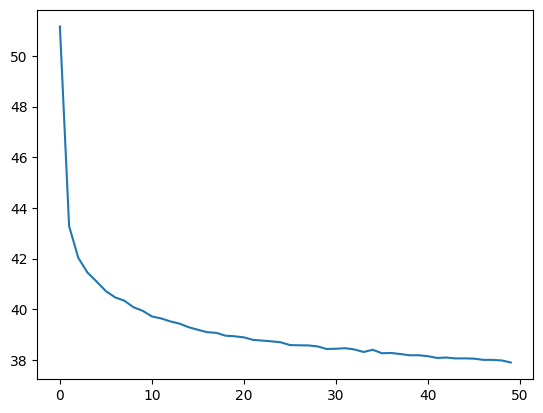

In [13]:
# show the loss value trends
plt.plot(losses)
plt.show()

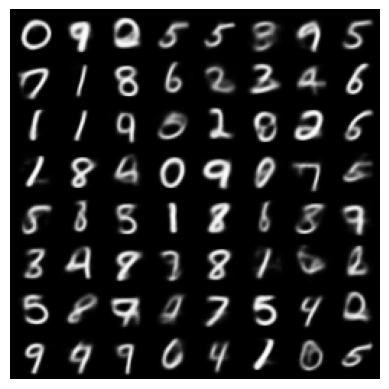

In [14]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, 4 * 4) # the 3 means times you use in model training
    x = model_norm.to('cpu').decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images
    , nrow=8
    , padding=2
    , normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [15]:
model_norm

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample1): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn_ds1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample2): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn_ds2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample3): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn_ds3): BatchNo